In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline


np.random.seed(4040)

In [2]:
# 生成训练数据
n = 4000
X, y = make_classification(n_samples=n, n_features=4)
data = pd.DataFrame(X, columns=['x1', 'x2', 'x3', 'x4'])
data['y'] = y

In [3]:
# 分别使用逻辑回归、决策树和决策树+逻辑回归建模
res = {}
train_data, test_data = train_test_split(data, test_size=0.5)
features = ['x1', 'x2', 'x3', 'x4']
label = 'y'
# 单独使用逻辑回归
logit_model = LogisticRegression()
logit_model.fit(train_data[features], train_data[label])
logit_prob = logit_model.predict_proba(test_data[features])[:, 1]
res['LR'] = roc_curve(test_data[label], logit_prob)

In [4]:
# 单独使用决策树
dt_model = DecisionTreeClassifier(max_depth=2)
dt_model.fit(train_data[features], train_data[label])
dt_prob = dt_model.predict_proba(test_data[features])[:, 1]
res['DT'] = roc_curve(test_data[label], dt_prob)

In [5]:
# 决策树和逻辑回归联结
# 为了防止过拟合，使用不同的数据训练决策树和逻辑回归
dt, lr = train_test_split(train_data, test_size=0.5)
# 使用决策树对前两个变量做变换
m = 2
_dt = DecisionTreeClassifier(max_depth=2)
_dt.fit(dt[features[:m]], dt[label])
leaf_node = _dt.apply(dt[features[:m]]).reshape(-1, 1)
coder = OneHotEncoder()
coder.fit(leaf_node)

def get_dt_feature(dt, coder, data):
    dt_feature = dt.apply(data[features[:m]]).reshape(-1, 1)
    # 为了避免虚拟变量陷阱，舍弃掉第一个虚拟变量
    return coder.transform(dt_feature).toarray()[:, 1:]

In [6]:
new_feature = np.c_[get_dt_feature(_dt, coder, lr), lr[features[m:]]]
_logit = LogisticRegression()
_logit.fit(new_feature, lr[label])
test_feature = np.c_[get_dt_feature(_dt, coder, test_data), test_data[features[m:]]]
dt_logit_prob = _logit.predict_proba(test_feature)[:, 1]
res['DT + LR'] = roc_curve(test_data[label], dt_logit_prob)

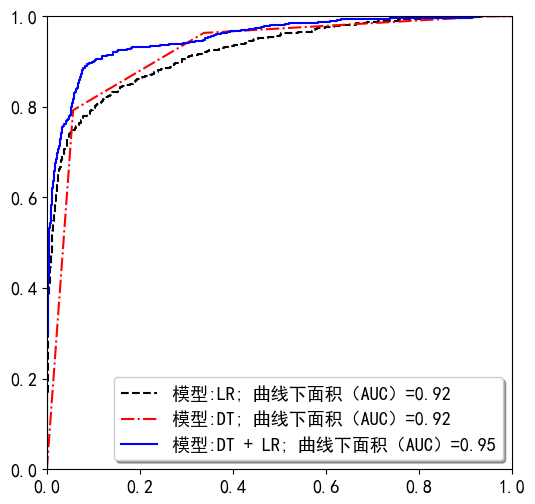

In [7]:
# 为在Matplotlib中显示中文，设置特殊字体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 正确显示负号
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 13})
# 创建一个图形框
fig = plt.figure(figsize=(6, 6), dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
styles = ['k--', 'r-.', 'b']
model = ['LR', 'DT', 'DT + LR']
for i, s in zip(model, styles):
    fpr, tpr, _ = res[i]
    _auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, s, label=f'模型:{i}; 曲线下面积（AUC）={_auc:.2f}')
    
legend = plt.legend(loc=4, shadow=True)
plt.savefig('dt_logit.png', dpi=200)
plt.show()